In [ ]:
# default_exp nnpu

In [ ]:
# export
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import losses
import tensorflow.keras.backend as K
import numpy as np
from scipy.stats import bernoulli
from easydict import EasyDict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 

import scipy.stats as ss

from sklearn.model_selection import train_test_split


from multiinstance.data.gaussian_dg import GaussianDG


# Data

In [ ]:
# args = EasyDict()
# args.data = EasyDict()
# args.data.alpha = 0.5
# args.data.n_p = 5000
# args.data.n_u =20000
# args.data.mu = 2
# args.data.sig = 1
# dg = GaussianDG(mu=args.data.mu,
#                 sig=args.data.sig,
#                 alpha=args.data.alpha,
#                 n_p=args.data.n_p,
#                 n_u=args.data.n_u)

# Model

In [ ]:
# export
class Basic(tf.keras.Model):

    def __init__(self, n_units, n_hidden, dropout_rate):
        super(Basic, self).__init__()
        self.Dens = list()
        self.BN = list()
        self.Drop = list()
        for i in np.arange(n_hidden):
            if i == 0:
                self.Dens.append(layers.Dense(n_units, activation='relu'))
            else:
                self.Dens.append(layers.Dense(n_units, activation='relu'))
            self.BN.append(layers.BatchNormalization())
            self.Drop.append(layers.Dropout(dropout_rate))
        self.dens_last = layers.Dense(1)
        # self.BN_last = layers.BatchNormalization()
        # self.sigmoid = activations.sigmoid()

    def call(self, inputs):
        for i in np.arange(len(self.Dens)):
            if i == 0:
                x = self.Dens[i](inputs)
            else:
                x = self.Dens[i](x)
            x = self.BN[i](x)
            x = self.Drop[i](x)
        x = self.dens_last(x)
        # x = self.BN_last(x)
        return activations.sigmoid(x)

# Loss

In [ ]:
# export
def NNPULoss(alpha):
    epsilon = 10 ** -10

    def loss_function(y_true, pn_posterior):
        i_zero = K.flatten(tf.equal(y_true, 0))
        i_one = K.flatten(tf.equal(y_true, 1))
        pn_posterior_0 = tf.boolean_mask(pn_posterior[:, 0], i_zero, axis=0)
        pn_posterior_1 = tf.boolean_mask(pn_posterior[:, 0], i_one, axis=0)
        loss_neg = -tf.reduce_mean(tf.math.log(1 - pn_posterior_0 + epsilon))
        loss_neg = tf.maximum(0.0, loss_neg + alpha * tf.reduce_mean(tf.math.log(1 - pn_posterior_1 + epsilon)))
        loss_pos = -alpha * tf.reduce_mean(tf.math.log(pn_posterior_1 + epsilon))
        return loss_neg + loss_pos

    return loss_function


def NNPUAbsLoss(alpha):
    epsilon = 10 ** -10

    def loss_function(y_true, pn_posterior):
        i_zero = K.flatten(tf.equal(y_true, 0))
        i_one = K.flatten(tf.equal(y_true, 1))
        pn_posterior_0 = tf.boolean_mask(pn_posterior[:, 0], i_zero, axis=0)
        pn_posterior_1 = tf.boolean_mask(pn_posterior[:, 0], i_one, axis=0)
        loss_neg = -tf.reduce_mean(tf.math.log(1 - pn_posterior_0 + epsilon))
        loss_neg = tf.math.abs(loss_neg + alpha * tf.reduce_mean(tf.math.log(1 - pn_posterior_1 + epsilon)))
        loss_pos = -alpha * tf.reduce_mean(tf.math.log(pn_posterior_1 + epsilon))
        return loss_neg + loss_pos

    return loss_function

# Utilities

In [ ]:
# export
def gradients(net, x, y, LossFnc):
    #YGen = np.cast['float32'](np.concatenate((y,pn_posterior_old, disc_posterior), axis=1))
    with tf.GradientTape() as tape:
        #pdb.set_trace()
        loss = LossFnc(y, net(x))
    return loss, tape.gradient(loss, net.trainable_variables)

In [ ]:
# export
def batch(x, y, n_p, n_u):
    x_p, ix_p = batchPos(x, y, n_p)
    x_u, ix_u = batchUL(x, y, n_u)
    xx = np.concatenate((x_p, x_u), axis=0)
    ix = np.concatenate((ix_p, ix_u), axis=0)
    return xx, y[ix, :], x_p, x_u, ix


def batchPos(x, y, n_p):
    return batchY(x, y, 1, n_p)


def batchUL(x, y, n_u):
    return batchY(x, y, 0, n_u)

def batchY(x, y, value, n, *args):
    ix = (y == value).flatten( )
    ix_all = np.arange(np.size(y))
    ix = ix_all[ix]
    if args:
        p = args[0].flatten()
        p = p[ix]
        ix_p = bernoulli.rvs(p)
        ix_p = np.cast['bool'](ix_p)
        ix = ix[ix_p]
    ix = np.random.choice(ix, n, replace=True)
    xx = x[ix, :]
    return xx, ix

In [ ]:
from sklearn.calibration import calibration_curve

In [ ]:
# export
def getPosterior(x,y,alpha,
                 inputs=None,
                 pupost=None,
                 training_args=EasyDict({"n_units":1000,
                                         "n_hidden":10,
                                         "dropout_rate":0.5,
                                         "maxIter":500,
                                         "batch_size":128}),
                 distributions=None,
                 viz_freq=10,
                 plotDistrs=False,
                absLoss=True,
                yPN=None):
    """
    x : (n x d) array
    y : (n x 1) array
    alpha : float
    training_args: EasyDict
        n_units : default 20 : size of hiddden layers
        n_hidden : default 10 : number of hidden layers
        dropout_rate : default 0.1 : drop percentage
        maxIter : default 100 : number of epochs
        batch_size : default 500 : batch size
    distributions : EasyDict :
        true_posterior(x) : callable
        f1(x) : callable
        f0(x) : callable
    viz_freq : default 10 : if distributions is specified, plot the 1D distributions at this period
    """
    # model
    net = Basic(training_args.n_units,
                training_args.n_hidden,
                training_args.dropout_rate)
    # loss
    if absLoss:
        LossFnc = NNPUAbsLoss(alpha)
    else:
        LossFnc = NNPULoss(alpha)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    if pupost is not None:
        inputs = pupost(x)
    elif inputs is not None:
        inputs = inputs
    else:
        inputs = x
    inputsTrain,inputsVal,labelsTrain,labelsVal = train_test_split(inputs,y)
    
    def plot():
        estimatedPosterior = net.predict(inputs)[:,0].ravel()
        truePosterior = distributions.true_posterior(x).ravel()
        plt.scatter(estimatedPosterior, truePosterior,alpha=.1,label="mae: {:.3f}".format(np.mean(np.abs(estimatedPosterior - truePosterior))))
        plt.plot([0,1],[0,1],color="black")
        plt.xlabel("estimated posterior")
        plt.ylabel("true posterior")
        #if yPN is not None:
        #    prob_true,prob_est = calibration_curve(yPN,estimatedPosterior,n_bins=10)
        #    plt.plot(prob_est, prob_true,label="NN (ECE: {:.3f},MAE: {:.3f})".format(np.mean(np.abs(prob_true - prob_est)),
         #                                                                           np.mean(np.abs(estimatedPosterior - truePosterior))),color="red")
        plt.legend()
        plt.show()
    minLoss,patience = np.inf,0
    for i in tqdm(range(training_args.maxIter),total=training_args.maxIter, leave=False):
        xx,yy,_,_,ix = batch(inputsTrain,labelsTrain,training_args.batch_size,training_args.batch_size)
        loss, grads = gradients(net,xx,yy,LossFnc)
        opt.apply_gradients(zip(grads, net.trainable_variables))
        valloss,_ = gradients(net,inputsVal, labelsVal,LossFnc)
        if valloss < minLoss:
            minLoss = valloss
            patience = 0
        else:
            patience += 1
        if distributions is not None and not i % viz_freq:
            plot()
        if patience == 50:
            break
    if distributions is not None:
        plot()
    return net.predict(inputs),net

In [ ]:
from multiinstance.data.gaussian_dg import GaussianMixtureDataGenerator

In [ ]:
dg = GaussianMixtureDataGenerator(100,1,[0.8,.9],1000,10000)

In [ ]:
[xPU,yPU,yPN] = dg.pu_data()

In [ ]:
xPUTrain,xPUVal,yPUTrain,yPUVal = train_test_split(xPU,yPU,test_size=.2)

$p(s=1|x) = \frac{p(s=1)}{p(s=1) + p(s=0) \cdot \frac{\alpha f_1 + (1-\alpha)f_0}{f_1}}$

max: $\frac{p(s=1)}{p(s=1) + p(s=0)\alpha}$

In [ ]:
estPUPost = tf.keras.models.Sequential([layers.Dense(25,activation=None),
                                        layers.BatchNormalization(),
                                        layers.Activation("relu"),
                                        layers.Dropout(.5),
                                        layers.Dense(25,activation=None),
                                        layers.BatchNormalization(),
                                        layers.Activation("relu"),
                                        layers.Dropout(.5),
                                        layers.Dense(25,activation=None),
                                        layers.BatchNormalization(),
                                        layers.Activation("relu"),
                                        layers.Dropout(.5),
                                        layers.Dense(2,activation="softmax")])
estPUPost.compile(tf.keras.optimizers.Adam(learning_rate=1e-3),loss=tf.keras.losses.BinaryCrossentropy())
estPUPost.fit(xPUTrain,tf.one_hot(yPUTrain[:,0],2),validation_data=(xPUVal,tf.one_hot(yPUVal[:,0],2)),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10,
                                                          restore_best_weights=True)],
              epochs=500,batch_size=64)

Epoch 1/500
138/138 [==============================] - 2s 4ms/step - loss: 0.6378 - val_loss: 0.4561
Epoch 2/500
138/138 [==============================] - 0s 3ms/step - loss: 0.4059 - val_loss: 0.3551
Epoch 3/500
138/138 [==============================] - 0s 3ms/step - loss: 0.3646 - val_loss: 0.3250
Epoch 4/500
138/138 [==============================] - 0s 3ms/step - loss: 0.3543 - val_loss: 0.3170
Epoch 5/500
138/138 [==============================] - 0s 3ms/step - loss: 0.3389 - val_loss: 0.3144
Epoch 6/500
138/138 [==============================] - 0s 3ms/step - loss: 0.3351 - val_loss: 0.3135
Epoch 7/500
138/138 [==============================] - 0s 3ms/step - loss: 0.3221 - val_loss: 0.3140
Epoch 8/500
138/138 [==============================] - 0s 3ms/step - loss: 0.3298 - val_loss: 0.3120
Epoch 9/500
138/138 [==============================] - 0s 3ms/step - loss: 0.3264 - val_loss: 0.3096
Epoch 10/500
138/138 [==============================] - 0s 3ms/step - loss: 0.3346 - val_lo

In [ ]:
from dist_curve.transforms import getOptimalTransform

In [ ]:
plt.scatter(estPUPost.predict(xPUVal)[:,1].ravel(),dg.pu_posterior(xPUVal).ravel())
plt.plot([0,1],[0,1],color="black")

NameError: name 'plt' is not defined

In [ ]:
roc_auc_score(yPUVal.astype(bool),
              estPUPost.predict(xPUVal)[:,1]),roc_auc_score(yPUVal.astype(bool),
                                                            dg.pu_posterior(xPUVal).ravel())

(0.5265286614383653, 0.5407026343649464)

# Train Using Estimated PU Posterior

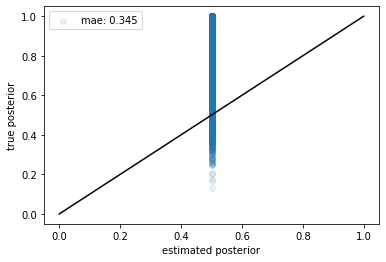

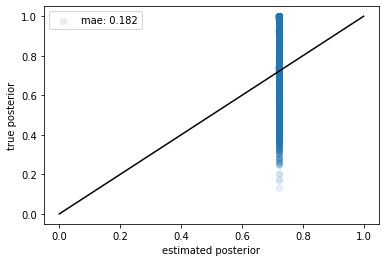

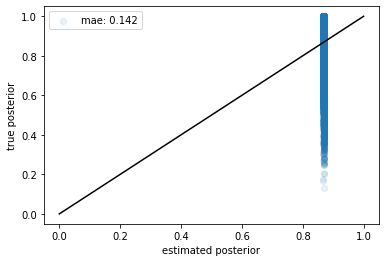

(array([[[0.8673092 ]],
 
        [[0.86906743]],
 
        [[0.8682133 ]],
 
        ...,
 
        [[0.8686914 ]],
 
        [[0.868832  ]],
 
        [[0.8681959 ]]], dtype=float32),
 <__main__.Basic at 0x7f878f9eb310>)

In [ ]:
getPosterior(xPU,yPU,dg.alpha,
             distributions=EasyDict({"true_posterior" : dg.pn_posterior_cc,
                                     "f1" : dg.dens_pos,
                                     "f0" : dg.dens_neg}),
             viz_freq=50,
             absLoss=True,
             yPN=yPN,
             pupost=lambda x: estPUPost.predict(x)[:,None],
             training_args=EasyDict({"n_units": 128,
                                     "n_hidden":10,
                                     "dropout_rate":0.5,
                                     "maxIter":10000,
                                     "batch_size":128}),)

# Train Using Raw Data

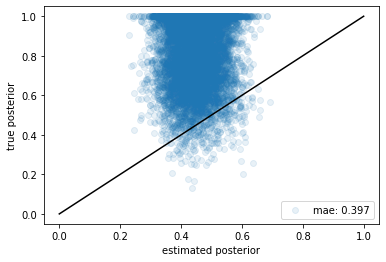

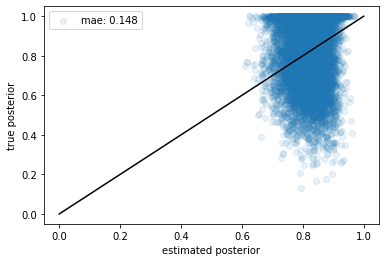

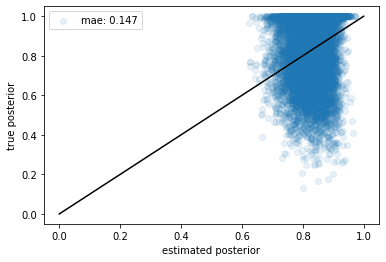

(array([[0.9130969 ],
        [0.8660884 ],
        [0.9051503 ],
        ...,
        [0.81238747],
        [0.76470536],
        [0.86933434]], dtype=float32),
 <__main__.Basic at 0x7f8785bc2190>)

In [ ]:
getPosterior(xPU,yPU,dg.alpha,
             distributions=EasyDict({"true_posterior" : dg.pn_posterior_cc,
                                     "f1" : dg.dens_pos,
                                     "f0" : dg.dens_neg}),
             viz_freq=50,
             absLoss=True,
             pupost=None,
             yPN=yPN,
             training_args=EasyDict({"n_units": 128,
                                     "n_hidden":3,
                                     "dropout_rate":0.5,
                                     "maxIter":10000,
                                     "batch_size":128}),)

# Train Using getOptimal

In [ ]:
scores,aucpu = getOptimalTransform(xPU,yPU.ravel())

In [ ]:
aucpu

0.49599325

In [ ]:
scores.shape

(11000,)

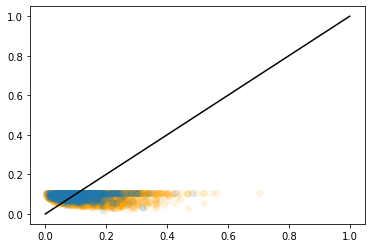

In [ ]:
plt.scatter(scores[~yPU.flatten().astype(bool)], dg.pu_posterior(xPU[~yPU.flatten().astype(bool)]),color="orange", alpha=.1)
plt.scatter(scores[yPU.flatten().astype(bool)], dg.pu_posterior(xPU[yPU.flatten().astype(bool)]),alpha=.1)
plt.plot([0,1],[0,1],color="black")

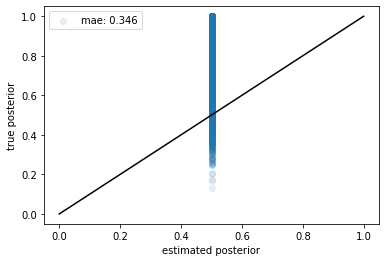

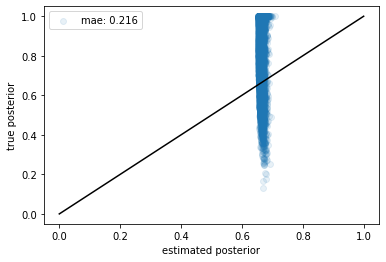

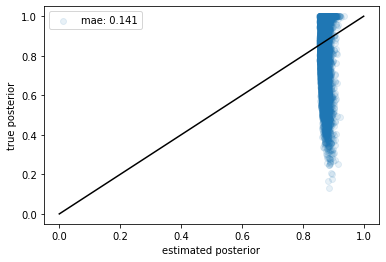

(array([[0.90015703],
        [0.89413404],
        [0.8617727 ],
        ...,
        [0.859969  ],
        [0.8723215 ],
        [0.87276304]], dtype=float32),
 <__main__.Basic at 0x7f878fcd5990>)

In [ ]:
getPosterior(xPU,yPU,dg.alpha,
             distributions=EasyDict({"true_posterior" : dg.pn_posterior_cc,
                                     "f1" : dg.dens_pos,
                                     "f0" : dg.dens_neg}),
             viz_freq=50,
             absLoss=True,
             pupost=None,
             inputs=scores[:,None],
             yPN=yPN,
             training_args=EasyDict({"n_units": 128,
                                     "n_hidden":10,
                                     "dropout_rate":0.5,
                                     "maxIter":10000,
                                     "batch_size":128}),)

In [ ]:
roc_auc_score(yPU,ranks)

0.6883235

# Train on Ranks

In [ ]:
ranks = ss.rankdata(dg.pu_posterior(xPU))[:,None]
ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())

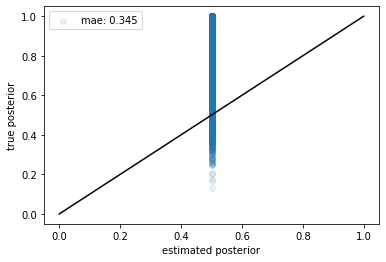

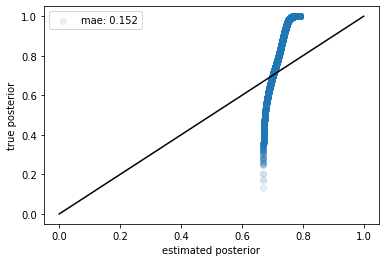

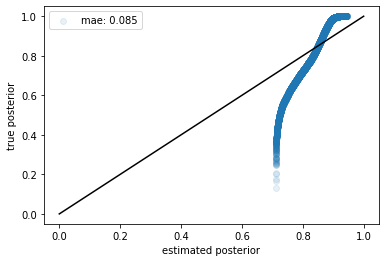

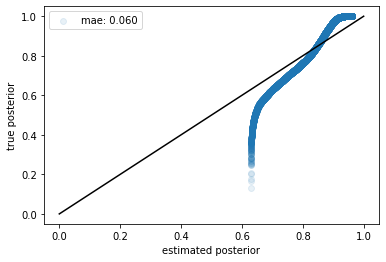

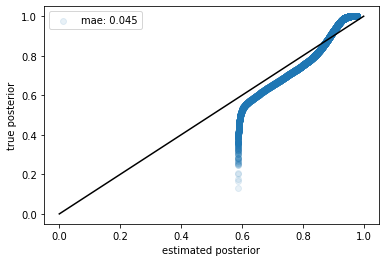

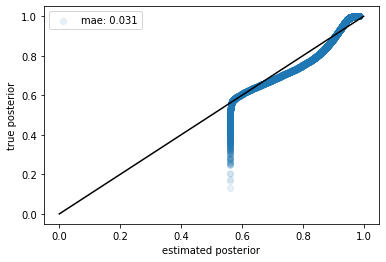

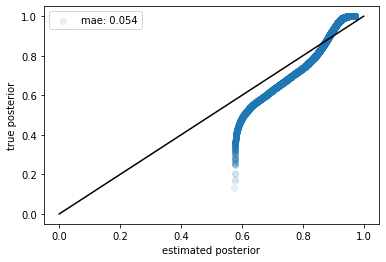

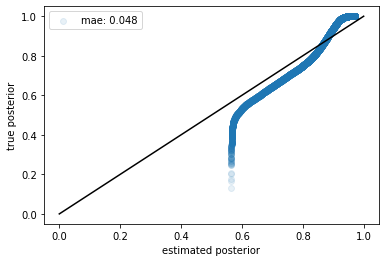

(array([[0.56536204],
        [0.9591699 ],
        [0.94763184],
        ...,
        [0.7990931 ],
        [0.5679965 ],
        [0.73407495]], dtype=float32),
 <__main__.Basic at 0x7f87867d6290>)

In [ ]:
getPosterior(xPU,yPU,dg.alpha,
             distributions=EasyDict({"true_posterior" : dg.pn_posterior_cc,
                                     "f1" : dg.dens_pos,
                                     "f0" : dg.dens_neg}),
             viz_freq=50,
             absLoss=True,
             pupost=None,
             inputs=ranks,
             yPN=yPN,
             training_args=EasyDict({"n_units": 128,
                                     "n_hidden":10,
                                     "dropout_rate":0.15,
                                     "maxIter":10000,
                                     "batch_size":128}),)

In [ ]:
dg.alpha

NameError: name 'dg' is not defined